# Homework 3: Visualizing Data with Movies

Name: 

Date: 

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [21]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip
import math

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [22]:
# define the path to the data folder
data_folder = '/Volumes/SanDisk/Data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

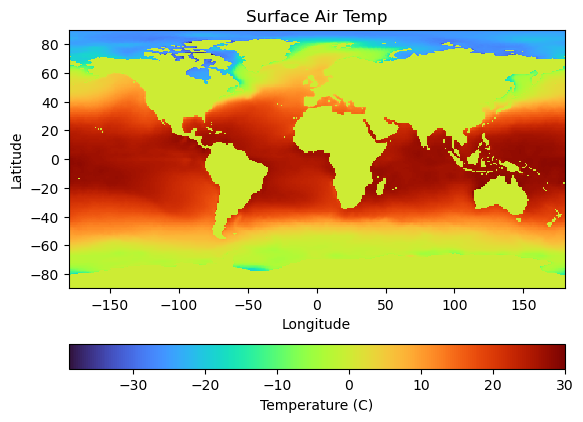

In [23]:
# read in the data
surfacetemp_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','EXFatemp','EXFatemp_2015_01.nc')

ds = xr.open_dataset(surfacetemp_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
surface_temp = np.array(ds['EXFatemp'])

ds.close()

surface_temp = surface_temp[0, :, :]

min_temp = 100
max_temp = 0

# Convert Kelvin to Celsius
for i in range(360):
    for j in range(720):
        # 0 Kelvin indicates landmass and not ocean surface
        if surface_temp[i][j] != 0:
            surface_temp[i][j] = surface_temp[i][j] - 273.15
            min_temp = min(min_temp, surface_temp[i][j])
            max_temp = max(max_temp, surface_temp[i][j])

# Get maximum and minimum temp for plot bounds
min_temp = math.floor(min_temp)
max_temp = math.ceil(max_temp)


# create a figure object
fig = plt.figure()

# plot the temperature
plt.pcolormesh(longitude, latitude, surface_temp, vmin=min_temp, vmax=max_temp, cmap= 'turbo')
plt.colorbar(orientation = 'horizontal', label="Temperature (C)")


# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temp')
plt.show()

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [24]:
# North Atlantic Ocean, between latitudes 15 and 45, longitude -98 and 12

# define the longitude/latitude bounds
min_lon = -98
max_lon = -10
min_lat = 15
max_lat = 45

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(latitude - min_lat))
max_row = np.argmin(np.abs(latitude - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))

Use the row and column bounds to subset the longitude, latitude, and your variable:

In [25]:
# subset the data

surface_temp = surface_temp[min_row: max_row]
surface_temp = surface_temp[:, min_col: max_col]
longitude = longitude[min_col: max_col]
latitude = latitude[min_row: max_row]

min_temp = 100
max_temp = 0
for i in range(max_row - min_row):
    for j in range(max_col - min_col):
        if surface_temp[i][j] != 0:
            min_temp = min(min_temp, surface_temp[i][j])
            max_temp = max(max_temp, surface_temp[i][j])

min_temp = math.floor(min_temp)
max_temp = math.ceil(max_temp)

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

-5


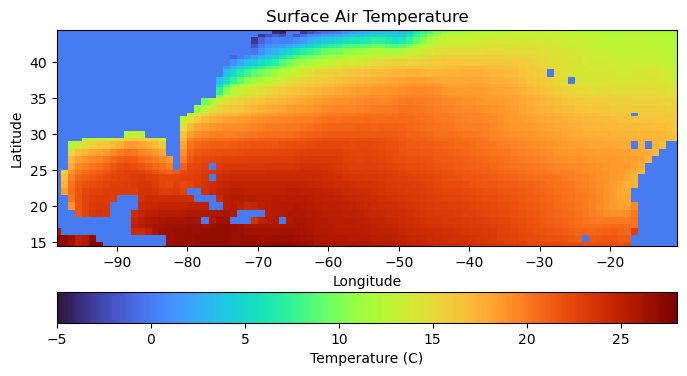

In [26]:
# make your figure here
# create a figure object
fig = plt.figure(figsize= (8,4))

print(min_temp)
# plot the 
plt.pcolormesh(longitude, latitude, surface_temp, vmin=min_temp, vmax=max_temp, cmap= 'turbo')


plt.colorbar(orientation = 'horizontal', label="Temperature (C)")



# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [27]:
def plot_panel(year,month, day = None):

    # Read in the data file
    file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','EXFatemp','EXFatemp_' + str(year) + '_' + '{:02d}'.format(month) + '.nc')

    ds = xr.open_dataset(file)
    longitude = np.array(ds['longitude'][:])
    latitude = np.array(ds['latitude'][:])
    surface_temp = np.array(ds['EXFatemp'])
    
    ds.close()
    
    surface_temp = surface_temp[0, :, :]

    #Subset the data
    # define the longitude/latitude bounds
    min_lon = -98
    max_lon = -10
    min_lat = 15
    max_lat = 45
    
    # compute the min/max row/col in the data grid
    min_row = np.argmin(np.abs(latitude - min_lat))
    max_row = np.argmin(np.abs(latitude - max_lat))
    min_col = np.argmin(np.abs(longitude - min_lon))
    max_col = np.argmin(np.abs(longitude - max_lon))

    surface_temp = surface_temp[min_row: max_row]
    surface_temp = surface_temp[:, min_col: max_col]
    longitude = longitude[min_col: max_col]
    latitude = latitude[min_row: max_row]

    # Convert Kelvin to Celsius
    for i in range(max_row - min_row):
        for j in range(max_col - min_col):

            # 0 Kelvin indicates landmass and not ocean surface
            if surface_temp[i][j] != 0:
                surface_temp[i][j] = surface_temp[i][j] - 273.15


    # Plot the subset data 
    fig = plt.figure()    
    
    # plot the 
    plt.pcolormesh(longitude, latitude, surface_temp, vmin=-5, vmax=32, cmap= 'turbo')
    
    
    plt.colorbar(orientation = 'horizontal', label="Temperature (C)")
    
    
    # format the axes
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('North Atlantic Ocean Surface Air Temperature')
    
    frames_directory = '/Users/account/Desktop/CS 185C/cs185c_fall2024/homework/homework_3/Frames'
    image_file = os.path.join(frames_directory,
                             'EXFatemp_' + str(year) + '_' + '{:02d}'.format(month) + '.png')
    plt.savefig(image_file)
    plt.close(fig)
    

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [28]:
# loop through the data and make a plot for each day
year = 2015
for month in range(1,13):
    for year in range(1997, 2016):
        plot_panel(year,month)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [29]:
# make a list of files for each movie panel
frames_directory = '/Users/account/Desktop/CS 185C/cs185c_fall2024/homework/homework_3/Frames'

file_list = []
for year in range(1997, 2016):
    for month in range(1, 13):
        
        panel_file = os.path.join(frames_directory,
                             'EXFatemp_' + str(year) + '_' + '{:02d}'.format(month) + '.png')
        file_list.append(panel_file)
        



In [30]:
# set the frames per second
fps=5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

# write the video to a file
# enter a file name
clip.write_videofile("North_Atlantic_Ocean_Surface_Air_Temperature.mp4")

Moviepy - Building video North_Atlantic_Ocean_Surface_Air_Temperature.mp4.
Moviepy - Writing video North_Atlantic_Ocean_Surface_Air_Temperature.mp4



Moviepy - Done !
Moviepy - video ready North_Atlantic_Ocean_Surface_Air_Temperature.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: It shows the process of the North Atlantic gyre where the southern ocean currents are warmer year round and temperatures start to cool down as it flows clockwise. The ocean surface air temperature also reflects this shift in temperature and the movie shows a pretty clear clockwise flow. 